## Imports


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay,roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from imblearn.over_sampling import SMOTE



SEED=0

In [3]:
diab = pd.read_csv('../diabetes_prediction_dataset.csv')
display(diab.head())

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## DataCleaning

In [4]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in diab.columns:
    if diab[col].dtype in ["int64", "float64"]:
        invalid_values[col] = [
            diab[col].isnull().sum(),
            diab[col].isna().sum(),
            (diab[col] < 0).sum(),
        ]
    else:
        invalid_values[col] = [diab[col].isnull().sum(), diab[col].isna().sum(), np.NaN]
invalid_values.index = ["Null count", "NaN count", "Negative count"]

display(invalid_values)
print("There are no null, NaN, or negative values in the dataset that need cleaning.\n")

print(f"Duplicated Rows: {diab.duplicated().sum()}")
# There are 3854 duplicate rows, let's drop them
diab_clean = diab.drop_duplicates().copy(True)

diab_clean["smoking_history_num"] = diab_clean["smoking_history"].map(
    {
        "No Info": 0,
        "never": 1,
        "ever": 2,
        "former": 3,
        "not current": 4,
        "current": 5,
    }
)

diab_clean["gender_num"] = diab_clean["gender"].map(
    {
        "Male": 0,
        "Female": 1,
        "Other": 2,
    }
)

print(f"There are {len(diab_clean)} clean rows left after dropping duplicates.")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854
There are 96146 clean rows left after dropping duplicates.


## Model Implementation And Analysis 

In [115]:
class ModelAnalysis:
    def __init__(self, models):
        self.models = models 

    def modelAnalysisSummary(self):
        modelsName = []
        preMacro = []
        recMacro=[]
        f1Macro=[]
        preWeighted=[]
        recWeighted=[]
        f1Weighted=[]

        for model in self.models:
            modelsName.append(model.name)
            report = model.report

            preMacro.append(report['precision']['macro avg'])
            recMacro.append(report['recall']['macro avg'])
            f1Macro.append(report['f1-score']['macro avg'])
            preWeighted.append(report['precision']['weighted avg'])
            recWeighted.append(report['recall']['weighted avg'])
            f1Weighted.append(report['f1-score']['weighted avg'])
        
        self.modelsReportData = {
            'Model': modelsName,
            'Precision (Macro)': preMacro,
            'Recall (Macro)': recMacro,
            'F1-Score (Macro)': f1Macro,
            "Precision (Weighted)": preWeighted,
            "Recall (Weighted)" : recWeighted,
            "F1-Score (Weighted)": f1Weighted
        }

        self.modelsReportDataFrame = pd.DataFrame(self.modelsReportData)
        display(self.modelsReportDataFrame.round(2))    
    
    def overAllMetricsPlot(self):
        df_print = self.modelsReportDataFrame.copy(deep=True)
        df_print.set_index("Model", inplace=True)
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        df_print[["Precision (Weighted)", "Recall (Weighted)", "F1-Score (Weighted)"]].plot(
            kind="barh", ax=axes[0], colormap="Pastel2")
        axes[0].set_title("Model Performance (Weighted Metrics)")
        axes[0].set_xlabel("Score")
        axes[0].set_xlim(0, 1.05)
        axes[0].invert_yaxis()
        
        df_print[["Precision (Macro)", "Recall (Macro)", "F1-Score (Macro)"]].plot(
            kind="barh", ax=axes[1], colormap="Pastel1"
        )
        axes[1].set_title("Model Performance (Macro Metrics)")
        axes[1].set_xlabel("Score")
        axes[1].set_xlim(0, 1.05)
        axes[1].invert_yaxis()

        plt.tight_layout()
        plt.show()
            

    def plottingMacroAndWeightedAvgs(self):
        metrics = ['Precision', 'Recall', 'F1-Score']
        fig, axes = plt.subplots(1, 3, figsize=(20,8))
        for idx, metric in enumerate(metrics):
            df_plot = self.modelsReportDataFrame.set_index("Model")[[f"{metric} (Macro)", f"{metric} (Weighted)"]]
            df_plot.plot(kind="barh", ax=axes[idx], colormap="Set2")
            axes[idx].set_title(f"{metric} - Macro vs Weighted")
            axes[idx].set_xlabel("Score")
            axes[idx].invert_yaxis()
        plt.tight_layout()
        plt.show()



class Model:
    def __init__(self, name, x_train=None, x_test=None, y_train=None, y_test=None):
        self.name = name  
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test        
        
    def report_model_performance(self):
        self.accuracy = accuracy_score(self.y_test, self.y_modelPredict)
        print(f"{self.name} Accuracy: {self.accuracy:.2f}")
        self.report = pd.DataFrame(classification_report(self.y_test, self.y_modelPredict, target_names=["No Diabetes", "Diabetes"], output_dict=True)).T        
        print(self.report.round(2))  
        self.confusionMatrix()        

    def confusionMatrix(self):
        cm = confusion_matrix(self.y_test, self.y_modelPredict)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix for {self.name}")
        plt.show()
        

    def rocCurve(self):
        fpr, tpr,_ = roc_curve(self.y_test, self.y_prob)        
        roc_auc = auc(fpr, tpr)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= self.name).plot()
        plt.title('ROC Curve')
        plt.show()

    
    def precisionRecallCurve(self):
        precision, recall,_= precision_recall_curve(self.y_test, self.y_prob)
        avg_prec = average_precision_score(self.y_test, self.y_prob)
        PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=avg_prec).plot()
        plt.show()
                        
    def testTrainSplit(self, features, labels, testSize):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            features, labels, test_size=0.2
        )   

    def predict(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_modelPredict = func(val)        
    
    def predictProb(self, func, val=None):
        if val is None:
            val = self.x_test
        self.y_prob = func(val)[:,1]

## Model Implementations with different feature Sets

Below is the list of models implemented and its efficiency is plotted. For each models different set of features are passed.

### Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76908
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23329.
Date:                Sun, 22 Jun 2025   Deviance:                       46658.
Time:                        16:12:57   Pearson chi2:                 2.08e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          -0.008115
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
HbA1c_level            -0.1708      0.009    -18.664      0.000      -0.189      -0.153
blood_glucose_level     0.0101      0.000     36.111      0.000       0.010       0.011
age                     0.0178      0.001     29.026      0.000       0.017       0.019
bmi                    -0.1208      0.002    -56.551      0.000      -0.125      -0.117
smoking_history_num     0.0003      0.008      0.037      0.971      -0.015       0.015
heart_disease           0.9532      0.045     21.022      0.000       0.864       1.042
hypertension            1.2632      0.036     35.084      0.000       1.193       1.334
gender_num             -0.8315      0.024    -34.138      0.000      -0.879      -0.784
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.91
              precision  recall  f1-score   support
No Diabetes        0.92    0.99      0.95  17562.00
Diabetes           0.46    0.07      0.13   1668.00
accuracy           0.91    0.91      0.91      0.91
macro avg          0.69    0.53      0.54  19230.00
weighted avg       0.88    0.91      0.88  19230.00


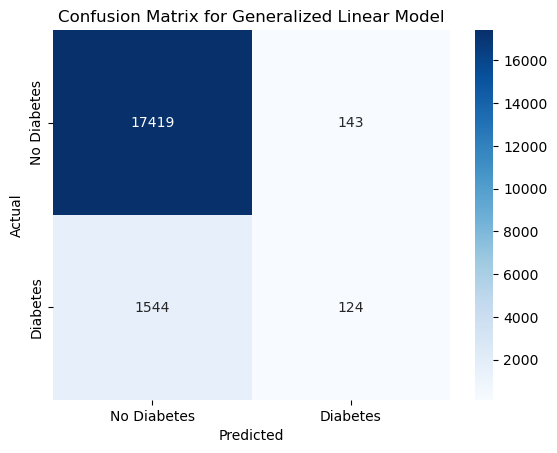

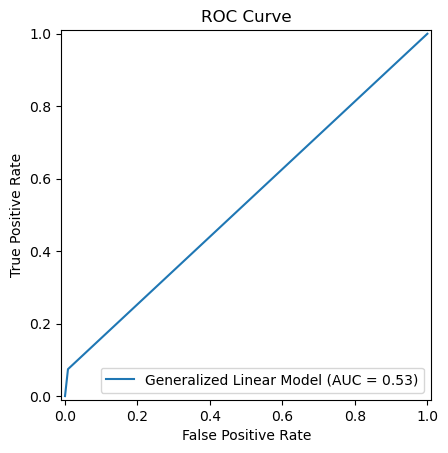

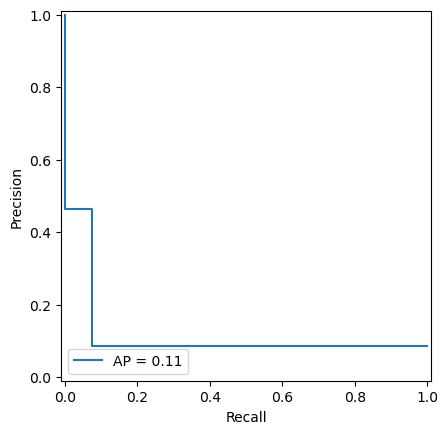

In [132]:
np.random.seed(SEED)

glm = Model("Generalized Linear Model")

glm.testTrainSplit(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
            "smoking_history_num",
            "heart_disease",
            "hypertension",
            "gender_num",
        ]
    ],
    labels=diab_clean["diabetes"],
    testSize=0.2)

fitResponse = sm.GLM(glm.y_train, glm.x_train, family=sm.families.Binomial()).fit()
display(fitResponse.summary())
glm.predict(fitResponse.predict)
glm.y_modelPredict = glm.y_modelPredict > 0.5
glm.y_prob = glm.y_modelPredict
glm.report_model_performance()
glm.rocCurve()
glm.precisionRecallCurve()


### Logistic Regression

Logistic Regression Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17562.00
Diabetes           0.87    0.63      0.73   1668.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.85  19230.00
weighted avg       0.96    0.96      0.96  19230.00


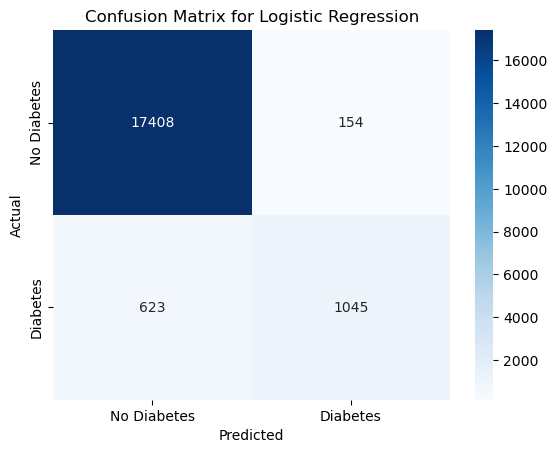

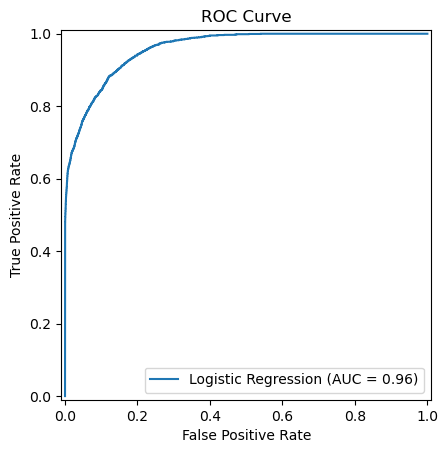

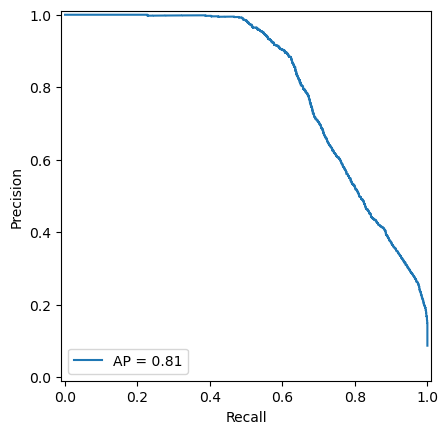

In [7]:
np.random.seed(SEED)

lr = Model("Logistic Regression")

lr.testTrainSplit(
    features= diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level",
            "age",
            "bmi",
        ]
    ],
    labels= diab_clean['diabetes'],
    testSize=0.2
)

lrModel = LogisticRegression()
lrModel.fit(lr.x_train, lr.y_train)
lr.predict(lrModel.predict)
lr.predictProb(lrModel.predict_proba)
lr.report_model_performance()
lr.rocCurve()
lr.precisionRecallCurve()

### KMeans Clustering

KMeans Clustering Accuracy: 0.50
              precision  recall  f1-score  support
No Diabetes        0.99    0.45      0.62  17562.0
Diabetes           0.14    0.97      0.25   1668.0
accuracy           0.50    0.50      0.50      0.5
macro avg          0.57    0.71      0.44  19230.0
weighted avg       0.92    0.50      0.59  19230.0


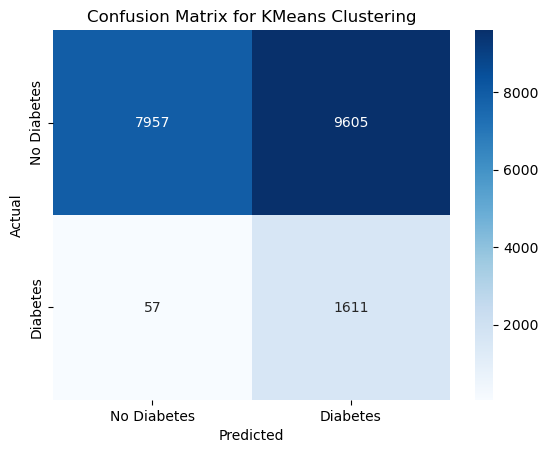

In [8]:
np.random.seed(SEED)

km = Model('KMeans Clustering')

km.testTrainSplit(
    features= diab_clean[
        ["age", 
         "bmi", 
         "blood_glucose_level"
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

scaler = StandardScaler()
kmModel = KMeans(n_clusters=2)
kmModel.fit(scaler.fit_transform(km.x_train))

km.predict(kmModel.predict, val=scaler.transform(km.x_test))
km.report_model_performance()

### K-Nearest Neighbors

K-Nearest Neighbors Accuracy: 0.97
              precision  recall  f1-score   support
No Diabetes        0.97    1.00      0.98  17562.00
Diabetes           1.00    0.68      0.81   1668.00
accuracy           0.97    0.97      0.97      0.97
macro avg          0.99    0.84      0.90  19230.00
weighted avg       0.97    0.97      0.97  19230.00


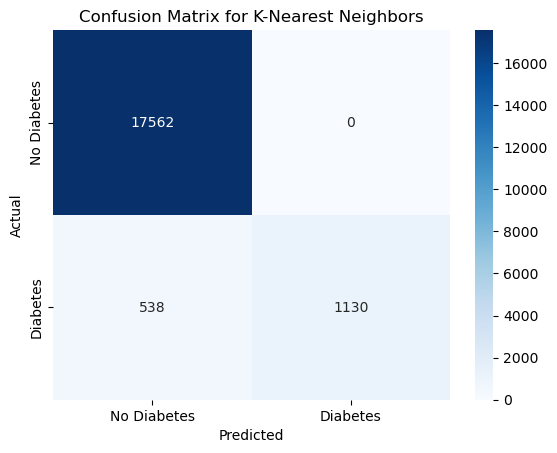

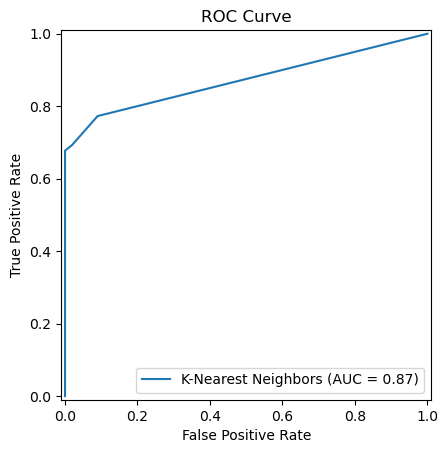

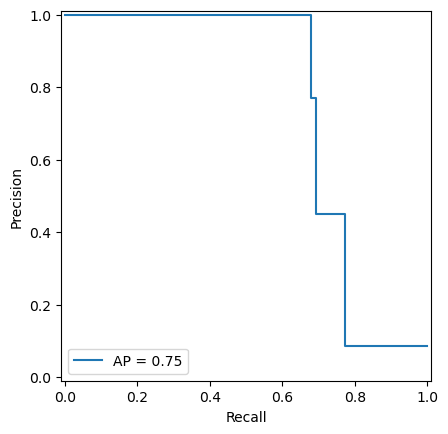

In [9]:
np.random.seed(SEED)

kn = Model("K-Nearest Neighbors")

kn.testTrainSplit(
    features=diab_clean[
        [
           'HbA1c_level',
            'blood_glucose_level' 
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

knModel = KNeighborsClassifier()
knModel.fit(kn.x_train, kn.y_train)
kn.predict(knModel.predict)
kn.predictProb(knModel.predict_proba)
kn.report_model_performance()
kn.rocCurve()
kn.precisionRecallCurve()

### Decision Tree Classifier

Decision Tree Classifier Accuracy: 0.87
              precision  recall  f1-score   support
No Diabetes        0.98    0.88      0.93  17562.00
Diabetes           0.38    0.80      0.52   1668.00
accuracy           0.87    0.87      0.87      0.87
macro avg          0.68    0.84      0.72  19230.00
weighted avg       0.93    0.87      0.89  19230.00


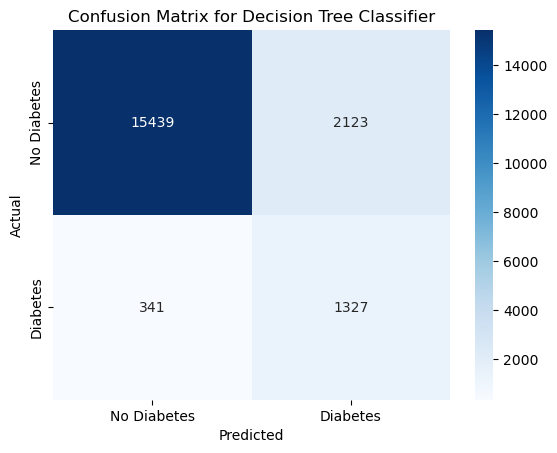

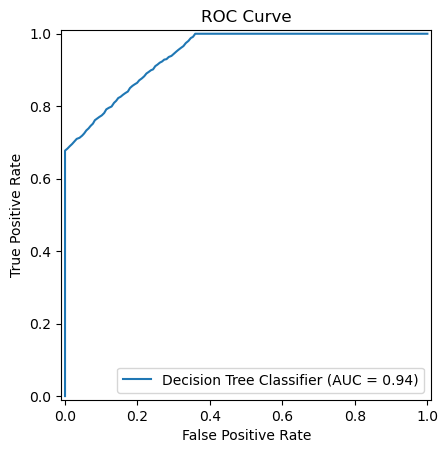

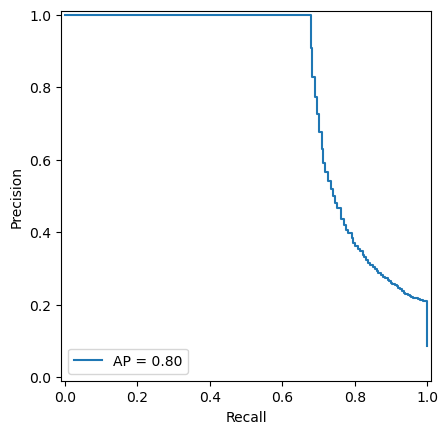

In [10]:
np.random.seed(SEED)

dtc = Model('Decision Tree Classifier')

dtc.testTrainSplit(
    features=diab_clean[
        [
             "HbA1c_level",
             "blood_glucose_level"   
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

dtcModel = tree.DecisionTreeClassifier(class_weight='balanced')
dtcModel.fit(dtc.x_train, dtc.y_train)
dtc.predict(dtcModel.predict)
dtc.predictProb(dtcModel.predict_proba)
dtc.report_model_performance()
dtc.rocCurve()
dtc.precisionRecallCurve()

### Decision Tree Classifier weighted for diabetes recall

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.67
              precision  recall  f1-score   support
No Diabetes        1.00    0.64      0.78  17555.00
Diabetes           0.21    1.00      0.35   1675.00
accuracy           0.67    0.67      0.67      0.67
macro avg          0.60    0.82      0.56  19230.00
weighted avg       0.93    0.67      0.74  19230.00


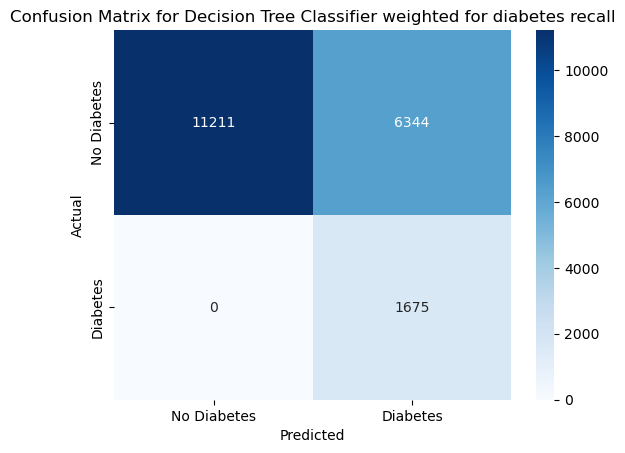

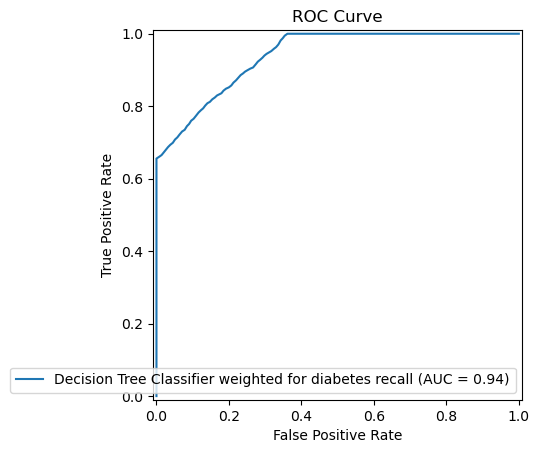

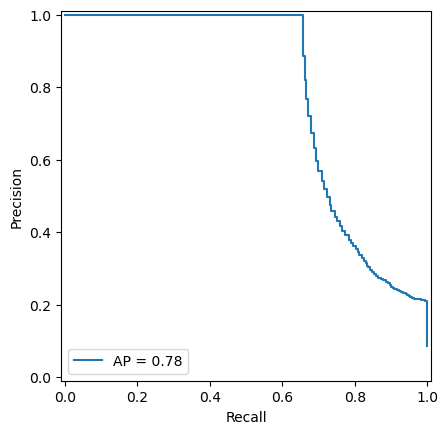

In [11]:
dtcRecall = Model('Decision Tree Classifier weighted for diabetes recall')

dtcRecall.testTrainSplit(
    features=diab_clean[
        [
             "HbA1c_level",
             "blood_glucose_level"   
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

dtcModelRecall = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
dtcModelRecall.fit(dtcRecall.x_train, dtcRecall.y_train)
dtcRecall.predict(dtcModelRecall.predict)
dtcRecall.predictProb(dtcModelRecall.predict_proba)
dtcRecall.report_model_performance()
dtcRecall.rocCurve()
dtcRecall.precisionRecallCurve()

### Decision Tree Classifier - SMOTE Resampled

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.88
              precision  recall  f1-score   support
No Diabetes        0.98    0.89      0.93  17562.00
Diabetes           0.39    0.79      0.53   1668.00
accuracy           0.88    0.88      0.88      0.88
macro avg          0.69    0.84      0.73  19230.00
weighted avg       0.93    0.88      0.89  19230.00


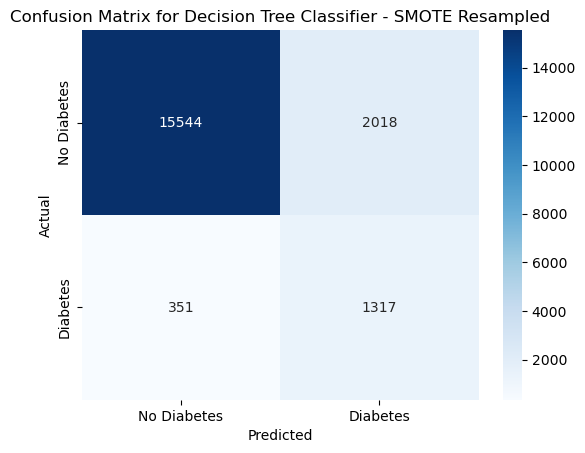

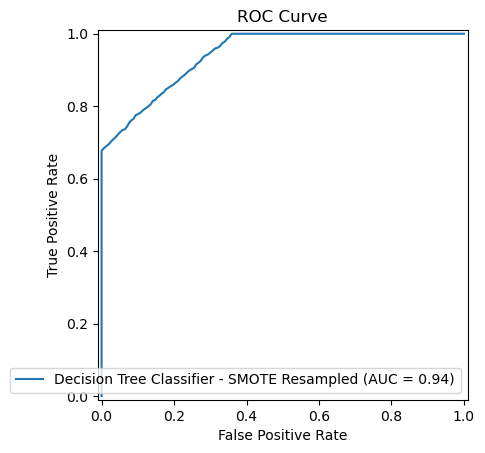

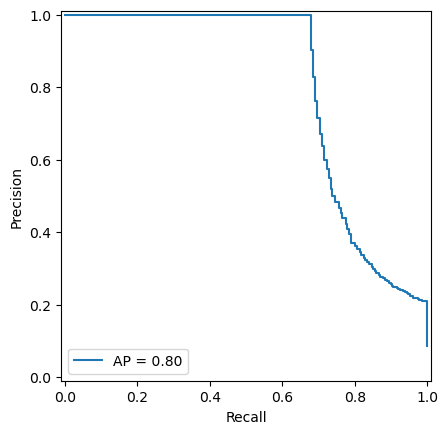

In [12]:
np.random.seed(SEED)

smote = Model('Decision Tree Classifier - SMOTE Resampled')

smote.testTrainSplit(
    features=diab_clean[
        [
            "HbA1c_level",
            "blood_glucose_level"
        ]
    ],
    labels=diab_clean['diabetes'],
    testSize=0.2
)

smoteModel = SMOTE()

smote.x_train, smote.y_train = smoteModel.fit_resample(smote.x_train, smote.y_train)

decisionTreeSmote = tree.DecisionTreeClassifier()
decisionTreeSmote.fit(smote.x_train, smote.y_train)

smote.predict(decisionTreeSmote.predict)
smote.predictProb(decisionTreeSmote.predict_proba)
smote.report_model_performance()
smote.rocCurve()
smote.precisionRecallCurve()

## Model Analysis

In [13]:
## Model Analysis Declaration

ma = ModelAnalysis([glm, lr, km, kn , dtc, dtcRecall, smote ])



### Models Summary

For models ran with the different feature selection, this below summary provides the efficiency of the each model. 

,Model,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Generalized Linear Model,0.69,0.53,0.54,0.88,0.91,0.88
1,Logistic Regression,0.92,0.81,0.85,0.96,0.96,0.96
2,KMeans Clustering,0.57,0.71,0.44,0.92,0.50,0.59
3,K-Nearest Neighbors,0.99,0.84,0.90,0.97,0.97,0.97
4,Decision Tree Classifier,0.68,0.84,0.72,0.93,0.87,0.89
5,Decision Tree Classifier weighted for diabetes...,0.60,0.82,0.56,0.93,0.67,0.74
6,Decision Tree Classifier - SMOTE Resampled,0.69,0.84,0.73,0.93,0.88,0.89


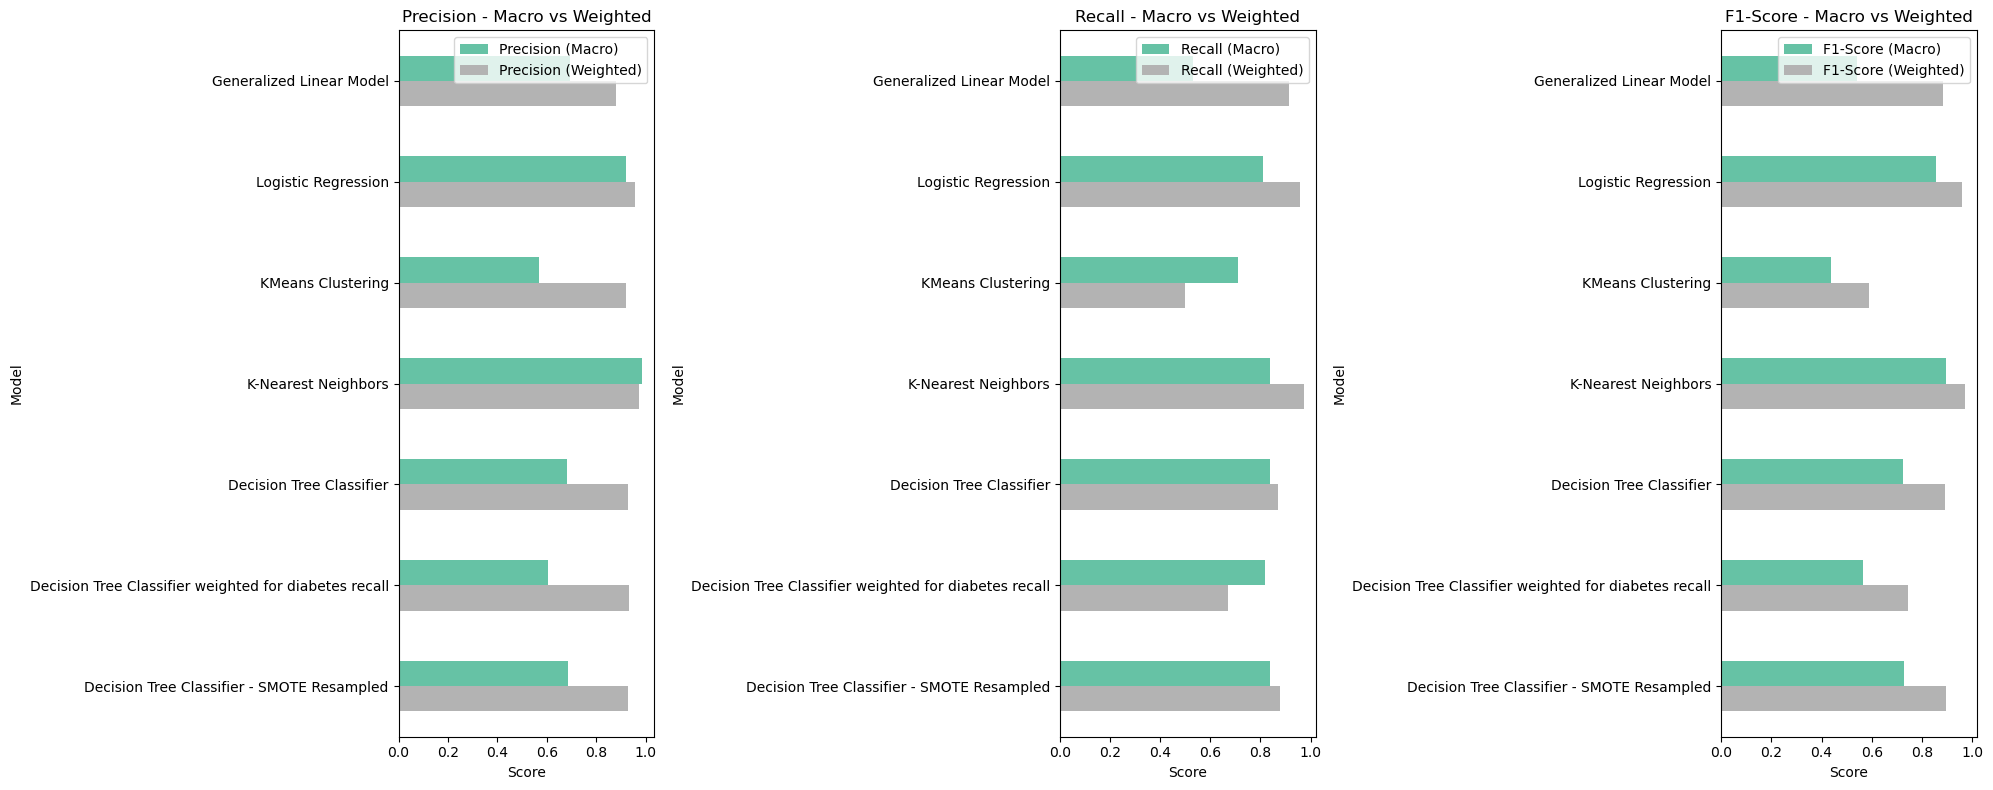

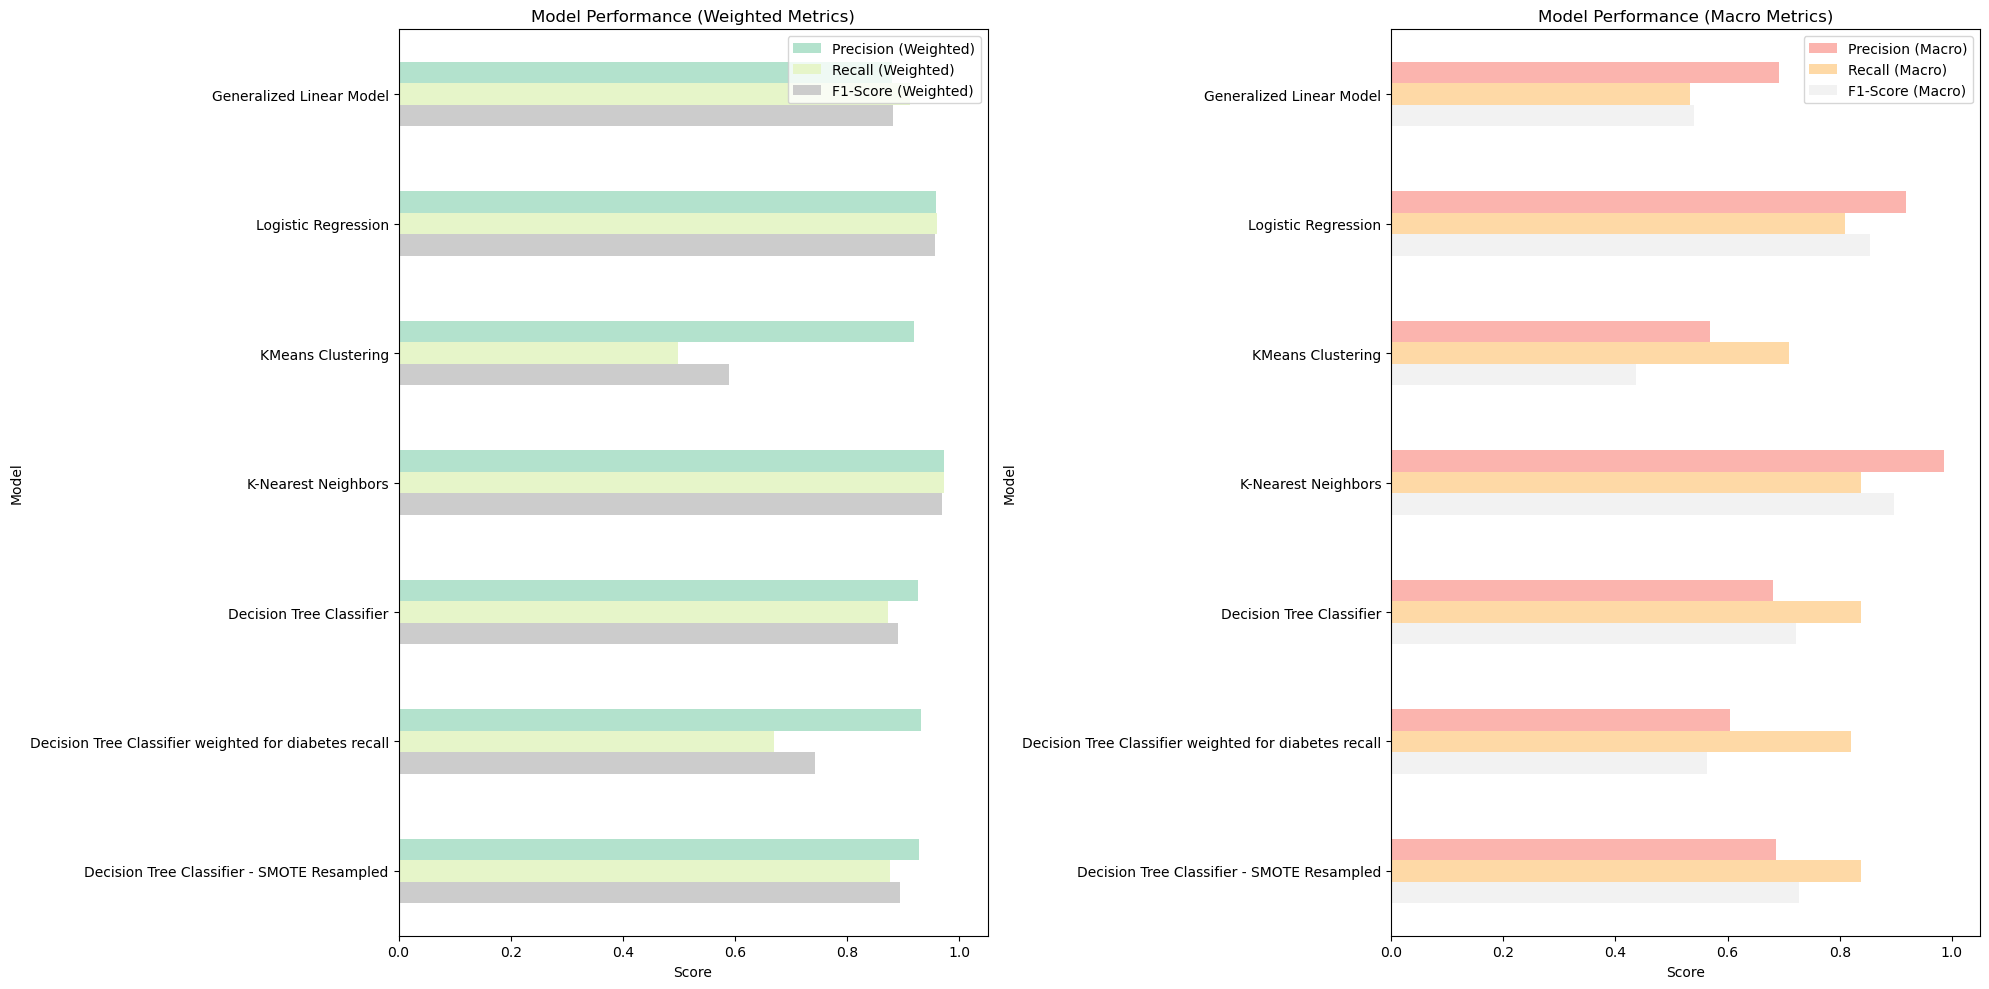

In [14]:
ma.modelAnalysisSummary()
ma.plottingMacroAndWeightedAvgs()
ma.overAllMetricsPlot()

## Model Comparison with Formal Feature Selection

Above comparison provided us with the data and effiency of each model under different feature selection. Now we are formally selecting the top features to predict the diabetes. 

In [171]:
class FormalModelComparision:
    def __init__ (self):
        self.diab_clean = diab_clean
        
    def selectTopFeatures(self,
                          top_n_anova=5,
                         top_n_chi2=5,
                         top_n_rf=5,
                         include_rfe=5):
        self.featureSelectionSummary()
        topFeatures = self.feature_selection_summary        
        anova_top = topFeatures["Anova F"].sort_values(ascending=False).head(top_n_anova).index
        chi2_top = topFeatures["Chi2"].sort_values(ascending=False).head(top_n_chi2).index
        rf_top = topFeatures["RF Importance"].sort_values(ascending=False).head(top_n_rf).index
        rfe_top = topFeatures["RFE Support"].sort_values(ascending=False).head(include_rfe).index
        
        self.topFeatures = set(anova_top).union(chi2_top).union(rf_top).union(rfe_top)        
        display(topFeatures.loc[list(self.topFeatures)])            
    
    def featureSelectionSummary(self):
        diab_clean_updated = diab_clean.drop(columns=['smoking_history_num', 'gender_num'])
        features = diab_clean_updated.drop(columns=['diabetes'])
        labels = diab_clean_updated['diabetes']
        features = pd.get_dummies(features)
        
        self.diab_clean_updated = diab_clean_updated
        self.features = features
        self.labels = labels
        
        # Normalize for chi2
        scaler = MinMaxScaler()
        features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
        
        
        # slect kBest 
        
        # Anova F-Test
        skb_f = SelectKBest(score_func=f_classif, k='all').fit(features, labels)
        anova_scores = pd.Series(skb_f.scores_, index=features.columns).sort_values(ascending=False)
        
        #Chi2
        skb_chi2 = SelectKBest(score_func=chi2, k='all').fit(features_scaled, labels)
        chi2_scores = pd.Series(skb_chi2.scores_, index=features.columns).sort_values(ascending=False)\
        
        
        # Random Forest Importances
        rf = RandomForestClassifier(random_state=0)
        rf.fit(features, labels)
        rf_scores = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=False)        
        
        # RFE - Logistic Regression
        lr = LogisticRegression(max_iter=4000)
        rfe = RFE(estimator=lr, n_features_to_select=8)
        rfe.fit(features, labels)
        rfe_support = pd.Series(rfe.support_, index=features.columns)
        
        
        self.feature_selection_summary = pd.DataFrame({
            "Anova F": anova_scores,    
            "Chi2": chi2_scores,
            "RF Importance": rf_scores,
            "RFE Support": rfe_support.astype(bool)
        })            



In [188]:
fmc = FormalModelComparision()
fmc.selectTopFeatures()
features = fmc.features[list(fmc.topFeatures)]
labels = fmc.labels

features = features.copy()
features['gender_Female'] = features['gender_Female'].map({True:1, False:0})
features['gender_Male'] = features['gender_Male'].map({True:1, False:0})
features['gender_Other'] = features['gender_Other'].map({True:1, False:0})


x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

,Anova F,Chi2,RF Importance,RFE Support
blood_glucose_level,21113.489195,2262.135136,0.324444,False
heart_disease,2885.951707,2687.582087,0.011628,True
gender_Female,137.298234,57.019068,0.002064,True
age,7257.356029,1021.343155,0.104736,False
bmi,4656.545262,137.150901,0.125518,False
hypertension,3829.202325,3396.838356,0.015809,True
HbA1c_level,19021.654018,1636.148704,0.397501,True
gender_Other,1.741926,1.741604,0.000001,True
gender_Male,138.177946,80.624462,0.002071,True


### Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76907
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8988.0
Date:                Sun, 22 Jun 2025   Deviance:                       17976.
Time:                        16:38:27   Pearson chi2:                 4.77e+04
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3045
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
blood_glucose_level     0.0334      0.001     61.786      0.000       0.032       0.034
heart_disease           0.7465      0.067     11.102      0.000       0.615       0.878
gender_Female         -27.2817      0.323    -84.488      0.000     -27.915     -26.649
age                     0.0474      0.001     38.475      0.000       0.045       0.050
bmi                     0.0885      0.003     31.142      0.000       0.083       0.094
hypertension            0.7952      0.052     15.255      0.000       0.693       0.897
HbA1c_level             2.3237      0.040     58.476      0.000       2.246       2.402
gender_Other          -46.6760   1.74e+04     -0.003      0.998   -3.41e+04     3.4e+04
gender_Male           -26.9863      0.321    -83.948      0.000     -27.616     -26.356
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17534.00
Diabetes           0.87    0.63      0.73   1696.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.86  19230.00
weighted avg       0.96    0.96      0.96  19230.00


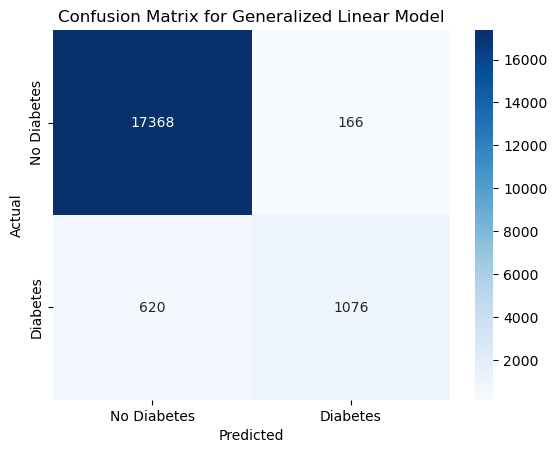

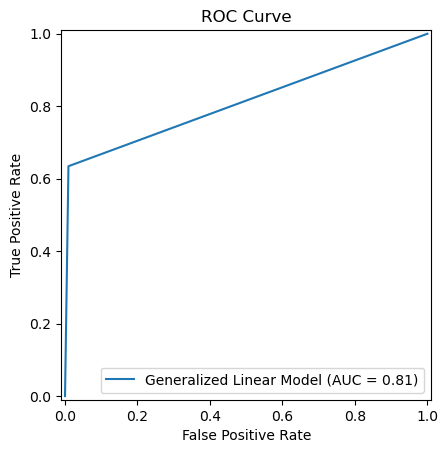

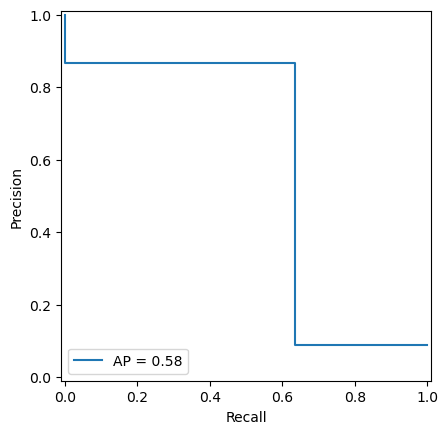

In [187]:
formal_glm = Model("Generalized Linear Model", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

fitResponse = sm.GLM(formal_glm.y_train, formal_glm.x_train, family=sm.families.Binomial()).fit()
display(fitResponse.summary())
formal_glm.predict(fitResponse.predict)
formal_glm.y_modelPredict = formal_glm.y_modelPredict > 0.5
formal_glm.y_prob = formal_glm.y_modelPredict
formal_glm.report_model_performance()
formal_glm.rocCurve()
formal_glm.precisionRecallCurve()

## Logistic Regression

Logistic Regression Accuracy: 0.96
              precision  recall  f1-score   support
No Diabetes        0.97    0.99      0.98  17534.00
Diabetes           0.87    0.63      0.73   1696.00
accuracy           0.96    0.96      0.96      0.96
macro avg          0.92    0.81      0.86  19230.00
weighted avg       0.96    0.96      0.96  19230.00


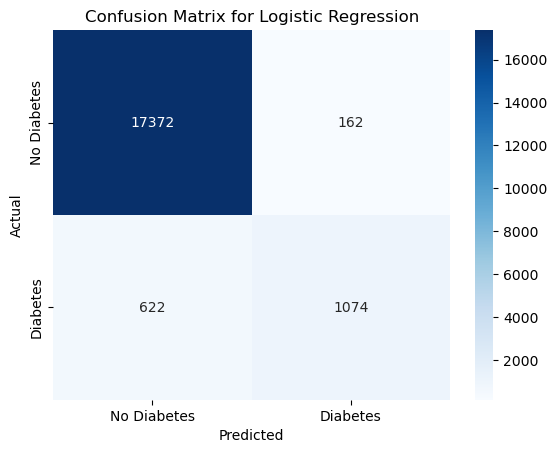

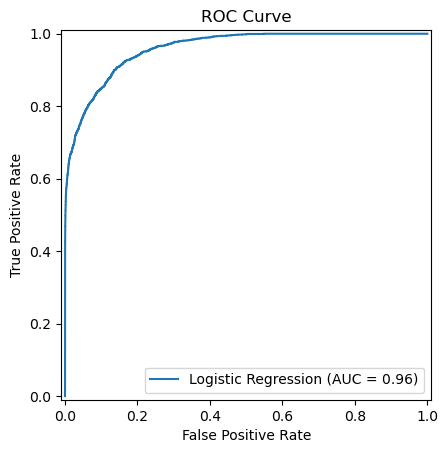

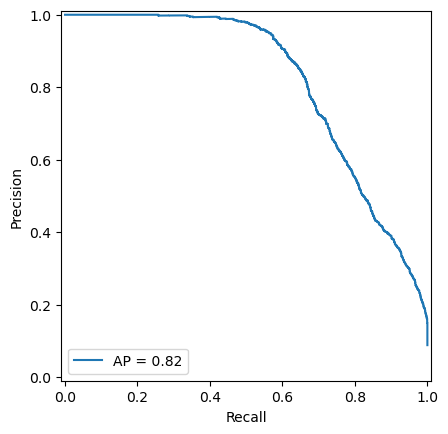

In [117]:
formal_logisticRegression = Model("Logistic Regression", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

lrModel = LogisticRegression(max_iter=4000)
lrModel.fit(formal_logisticRegression.x_train, formal_logisticRegression.y_train)
formal_logisticRegression.predict(lrModel.predict)
formal_logisticRegression.predictProb(lrModel.predict_proba)
formal_logisticRegression.report_model_performance()
formal_logisticRegression.rocCurve()
formal_logisticRegression.precisionRecallCurve()

## K-Nearest Neighbors


K Nearest Neighbors Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.96    0.99      0.98  17534.00
Diabetes           0.88    0.55      0.68   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.92    0.77      0.83  19230.00
weighted avg       0.95    0.95      0.95  19230.00


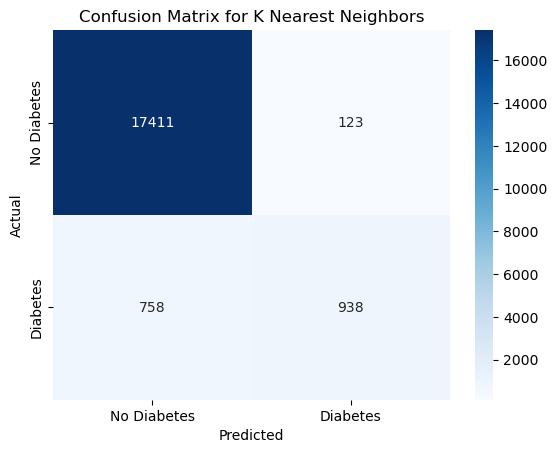

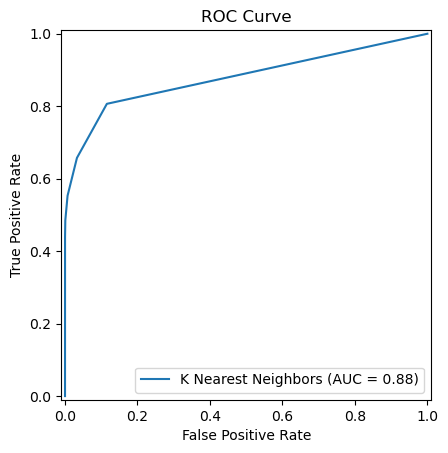

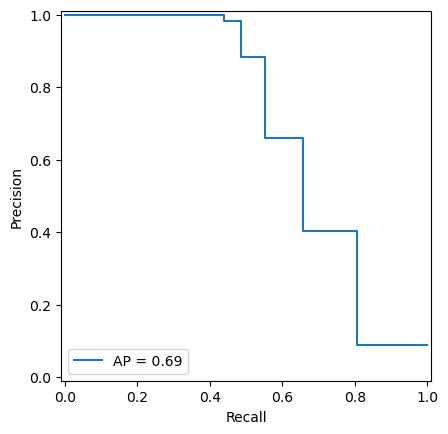

In [119]:
formal_knn = Model("K Nearest Neighbors", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
knModel = KNeighborsClassifier()
knModel.fit(formal_knn.x_train, formal_knn.y_train)
formal_knn.predict(knModel.predict)
formal_knn.predictProb(knModel.predict_proba)
formal_knn.report_model_performance()
formal_knn.rocCurve()
formal_knn.precisionRecallCurve()

## Decision Tree Classifier Balanced

Decision Tree Classifier Balanced Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.97    0.97      0.97  17534.00
Diabetes           0.71    0.74      0.73   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.84    0.86      0.85  19230.00
weighted avg       0.95    0.95      0.95  19230.00


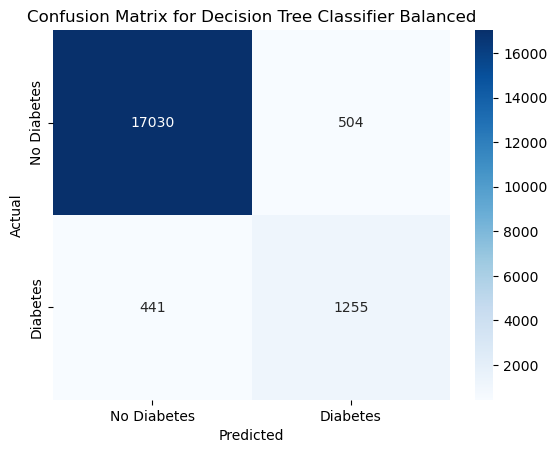

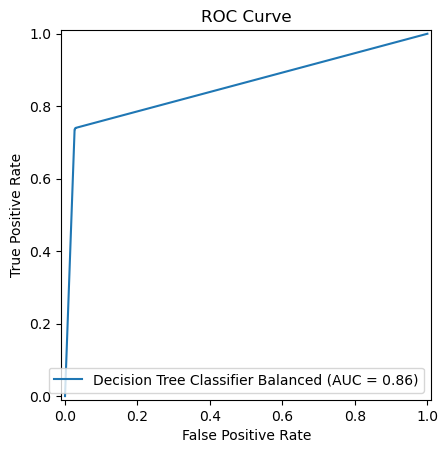

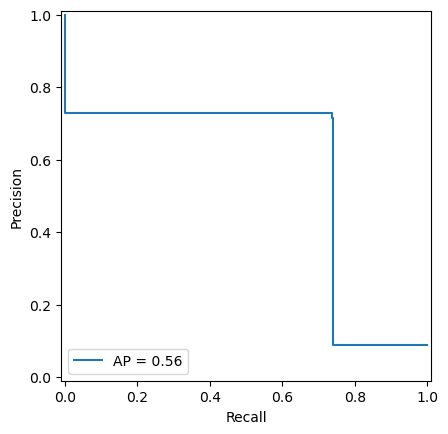

In [120]:
formal_dcc_balanced = Model("Decision Tree Classifier Balanced", x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
dtcModel = tree.DecisionTreeClassifier(class_weight='balanced')
dtcModel.fit(formal_dcc_balanced.x_train, formal_dcc_balanced.y_train)
formal_dcc_balanced.predict(dtcModel.predict)
formal_dcc_balanced.predictProb(dtcModel.predict_proba)
formal_dcc_balanced.report_model_performance()
formal_dcc_balanced.rocCurve()
formal_dcc_balanced.precisionRecallCurve()

## Decision Tree Classifier weighted for diabetes recall

Decision Tree Classifier weighted for diabetes recall Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.97    0.97      0.97  17534.00
Diabetes           0.74    0.74      0.74   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.86    0.86      0.86  19230.00
weighted avg       0.95    0.95      0.95  19230.00


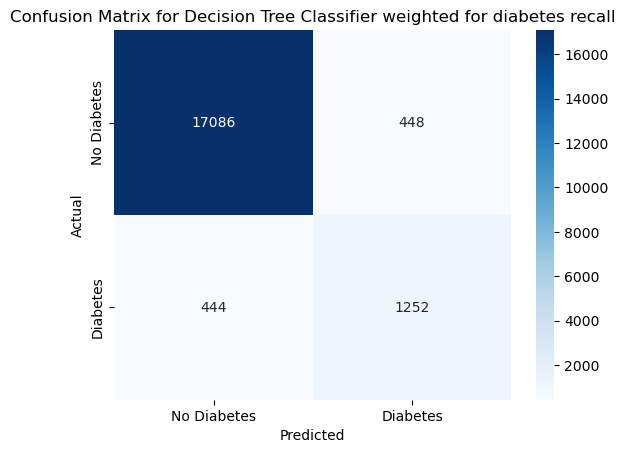

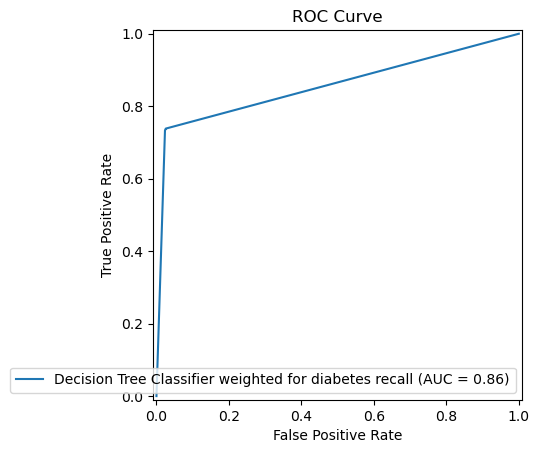

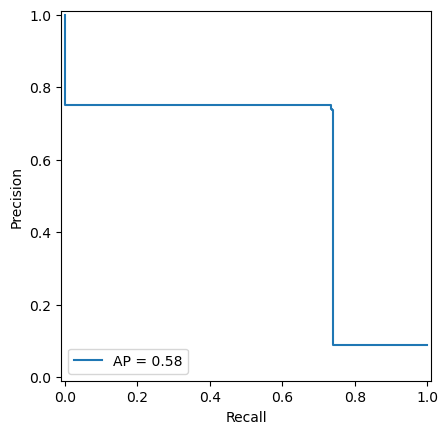

In [121]:
formal_dtcRecall = Model('Decision Tree Classifier weighted for diabetes recall', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

dtcModelRecall = tree.DecisionTreeClassifier(class_weight={0: 1, 1: 20})
dtcModelRecall.fit(formal_dtcRecall.x_train, formal_dtcRecall.y_train)
formal_dtcRecall.predict(dtcModelRecall.predict)
formal_dtcRecall.predictProb(dtcModelRecall.predict_proba)
formal_dtcRecall.report_model_performance()
formal_dtcRecall.rocCurve()
formal_dtcRecall.precisionRecallCurve()

### Decision Tree Classifier - SMOTE Resampled

Decision Tree Classifier - SMOTE Resampled Accuracy: 0.95
              precision  recall  f1-score   support
No Diabetes        0.97    0.97      0.97  17534.00
Diabetes           0.72    0.74      0.73   1696.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.85    0.86      0.85  19230.00
weighted avg       0.95    0.95      0.95  19230.00


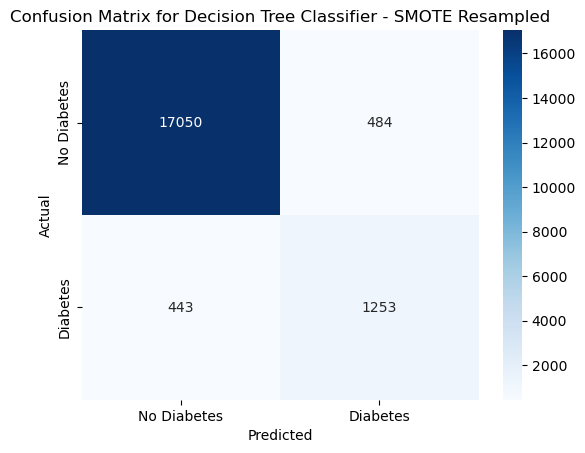

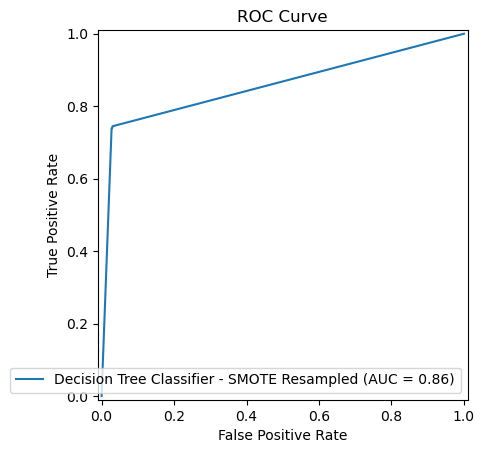

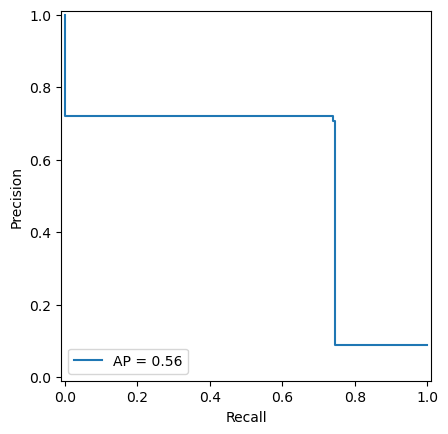

In [122]:

formal_smote = Model('Decision Tree Classifier - SMOTE Resampled', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
smoteModel = SMOTE()

smote.x_train, smote.y_train = smoteModel.fit_resample(formal_smote.x_train, formal_smote.y_train)

decisionTreeSmote = tree.DecisionTreeClassifier()
decisionTreeSmote.fit(formal_smote.x_train, formal_smote.y_train)

formal_smote.predict(decisionTreeSmote.predict)
formal_smote.predictProb(decisionTreeSmote.predict_proba)
formal_smote.report_model_performance()
formal_smote.rocCurve()
formal_smote.precisionRecallCurve()

## Model Analysis



In [190]:
formal_ma = ModelAnalysis([formal_glm, formal_logisticRegression, formal_knn, formal_dcc_balanced, formal_dtcRecall, formal_smote])

### Model Summary

By Comparing the overall analysis, results of models with the random feature selection vs formalized feature selection, later efficieny would have been increased and provide us with the more accurate response.

,Model,Precision (Macro),Recall (Macro),F1-Score (Macro),Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Generalized Linear Model,0.92,0.81,0.86,0.96,0.96,0.96
1,Logistic Regression,0.92,0.81,0.86,0.96,0.96,0.96
2,K Nearest Neighbors,0.92,0.77,0.83,0.95,0.95,0.95
3,Decision Tree Classifier Balanced,0.84,0.86,0.85,0.95,0.95,0.95
4,Decision Tree Classifier weighted for diabetes...,0.86,0.86,0.86,0.95,0.95,0.95
5,Decision Tree Classifier - SMOTE Resampled,0.85,0.86,0.85,0.95,0.95,0.95


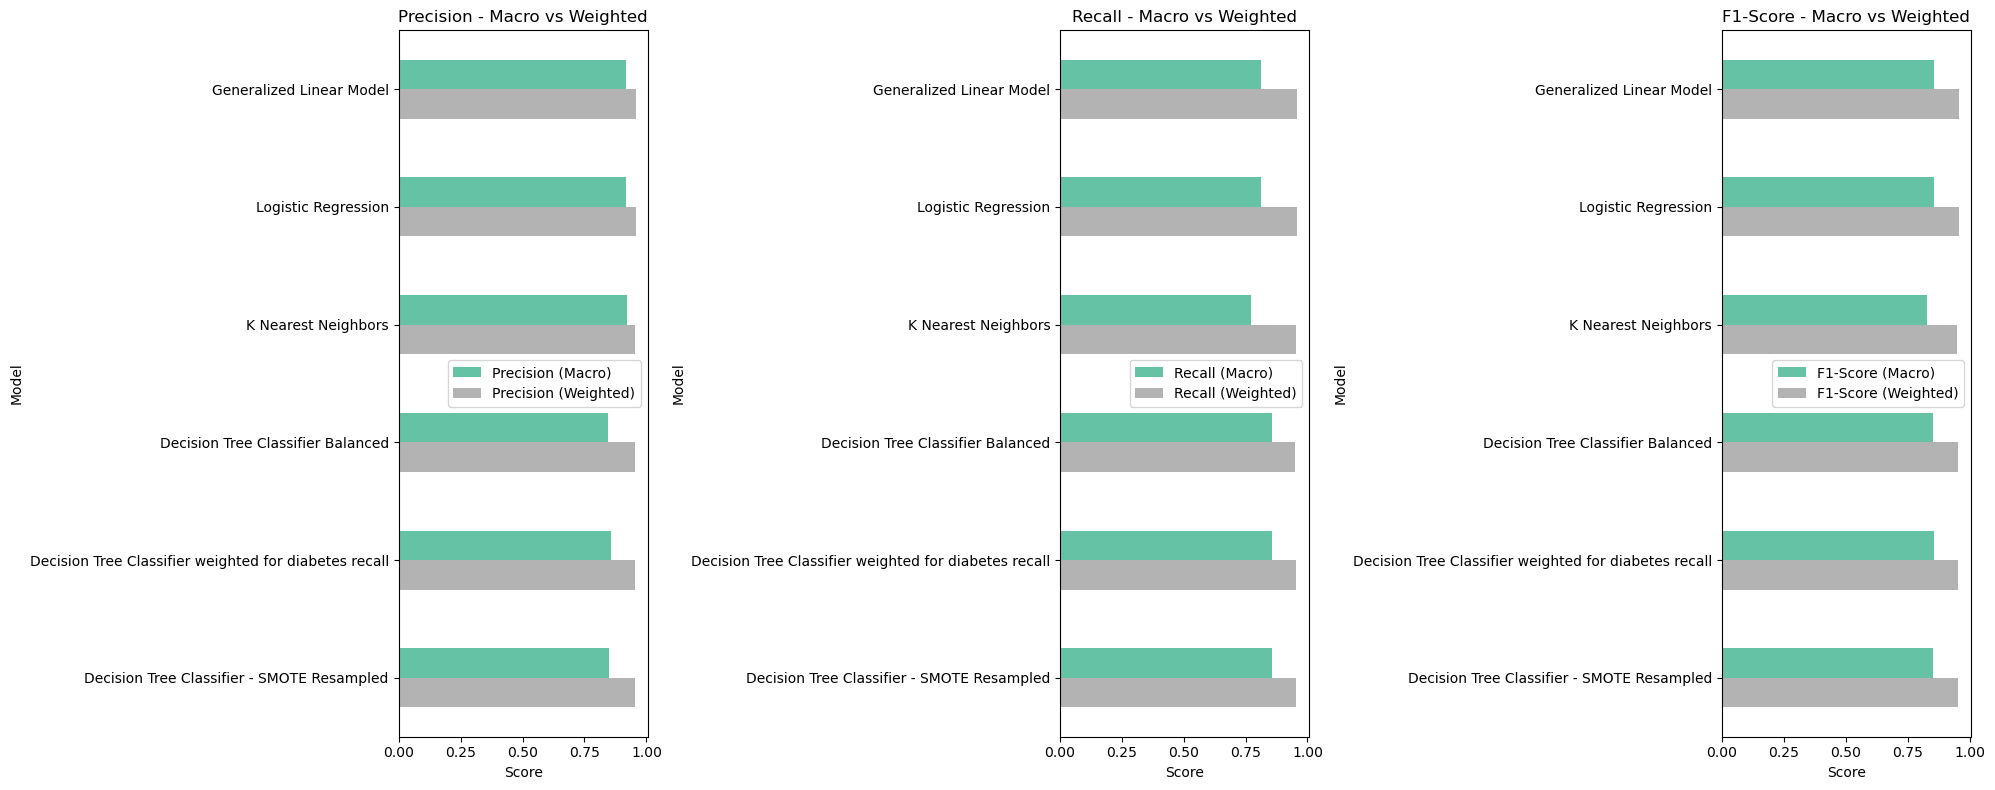

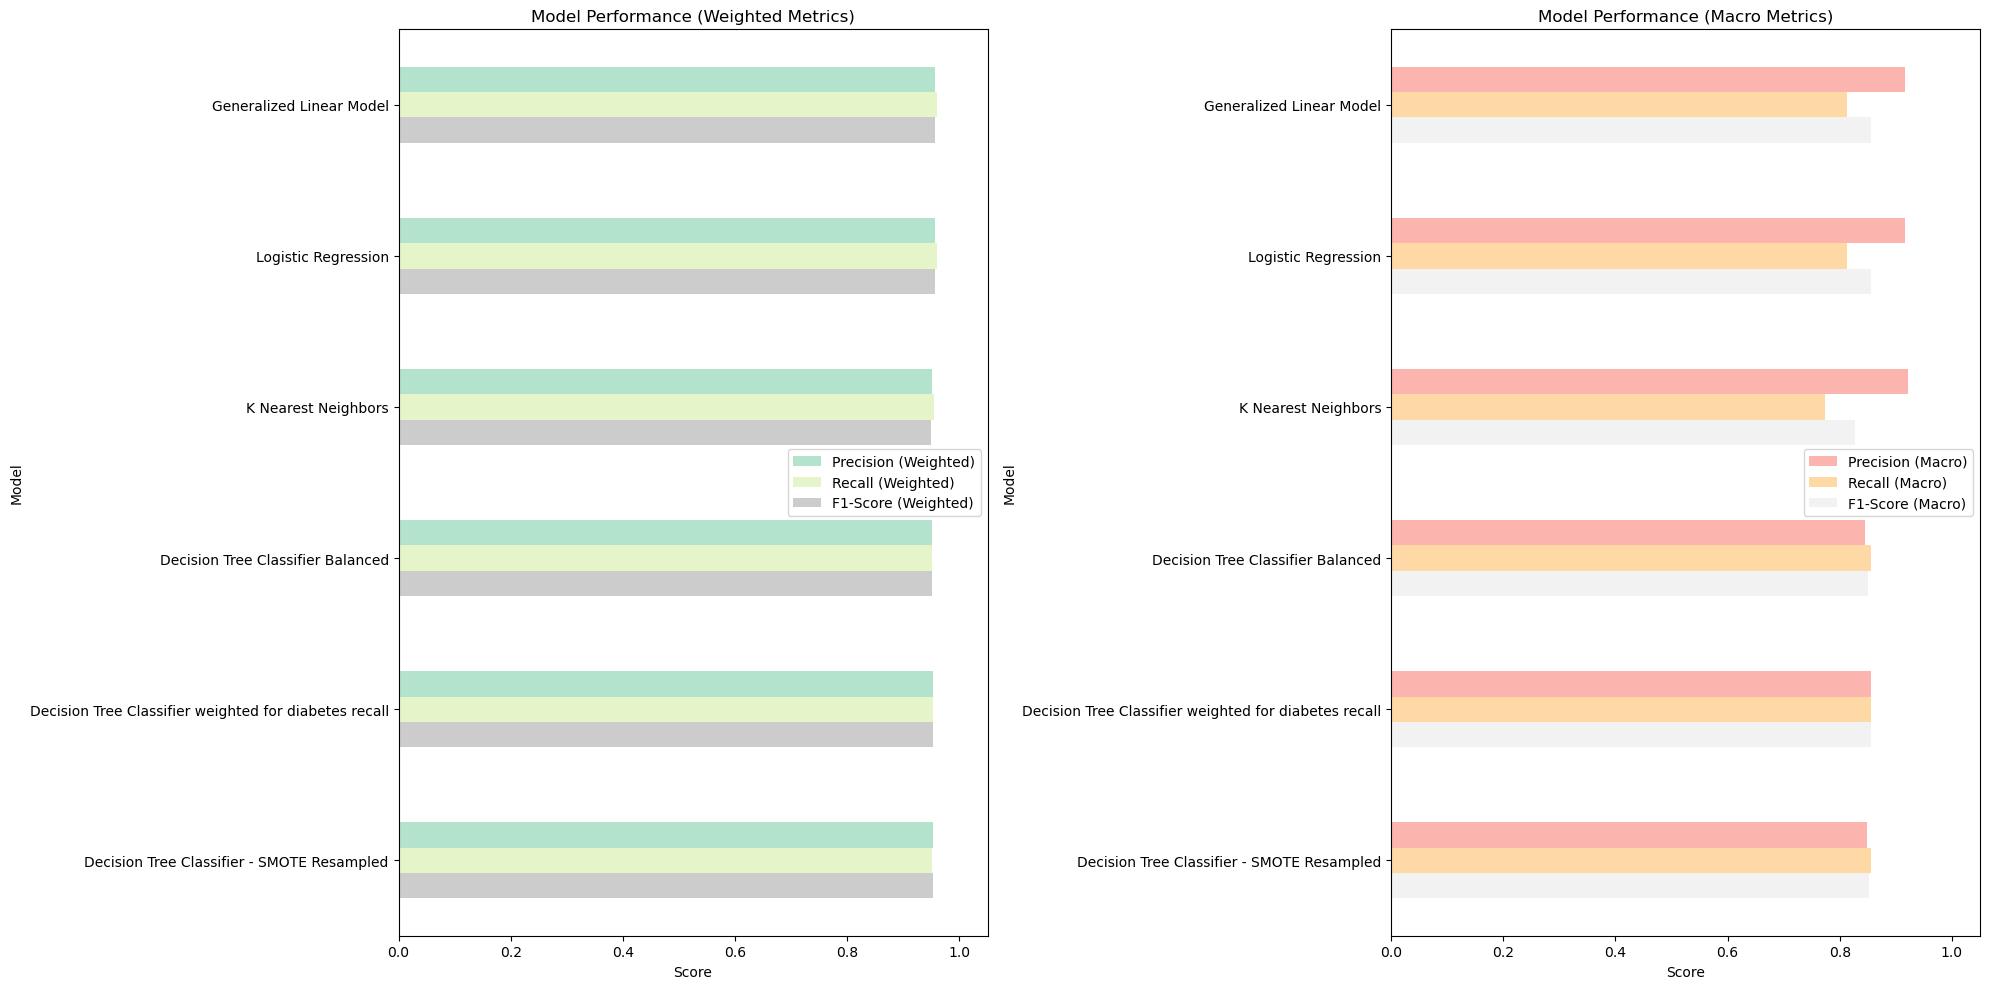

In [191]:
formal_ma.modelAnalysisSummary()
formal_ma.plottingMacroAndWeightedAvgs()
formal_ma.overAllMetricsPlot()